# MNIST Multilayer Perceptron in Tensorflow

Author: Juvid Aryaman

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
sys.path.append("..")
import utls
utls.reset_plots()

MNIST is a dataset of 28$\times$28 handwritten digits. The dataset comes shipped with tensorflow, so let's load it up and have a look.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [4]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [5]:
n_train = x_train.shape[0]
n_test = x_test.shape[0]

Plot some example images

In [6]:
from matplotlib import cm

Digit: 8


/home/juvid/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


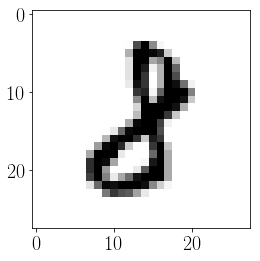

In [7]:
example = np.random.choice(np.arange(n_train))

image = x_train[example]
label = y_train[example]

plt.imshow(image, cmap = cm.binary)
print("Digit: {}".format(label))

For a multilayer perceptron, we will discard the spatial correlations and simply flatten the data. A convolutional neural network doesn't do this, and is a smarter choice for image data, but we'll start off simple here.

In [8]:
x_train_flat = x_train.reshape((n_train, -1))
x_test_flat = x_test.reshape((n_test, -1))
x_train_flat.shape, x_test_flat.shape

((60000, 784), (10000, 784))

Now we encode the data labels as one-hot vectors

In [9]:
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=uint8)

In [10]:
def one_hot(labels):
    """
    Encodes a list of labels ranging between (0-9) as one-hot vectors.
    0 -> [1,0,0,0,0,0,0,0,0,0]
    9 -> [0,0,0,0,0,0,0,0,0,1]
    """
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0]*10
        one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    return np.array(one_hot_labels).astype(np.float32)

In [11]:
y_train_oh = one_hot(y_train)
y_test_oh = one_hot(y_test)
y_train_oh.shape, y_test_oh.shape

((60000, 10), (10000, 10))

In [12]:
y_train[0],y_train_oh[0]

(5, array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32))

## Build multilayer perceptron

In [13]:
class MLP_MNIST:
    """
    Define a multilayer perceptron for the MNIST dataset
    
    Params
    ------------
    wd_factor : A double, the L2 regularisation factor for model parameters
    learning_rate : A double, the learning rate for the Adam optimiser    
    
    """
    def __init__(self, wd_factor, learning_rate):
        self.wd_factor = wd_factor # weight decay factor (L2 regulariser)
        self.learning_rate = learning_rate
        self.train_pointer = 0 # for mini-batch housekeeping
        self.test_pointer = 0
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None,784],name="input")
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None,10],name="ground_truth")
        print(self.input)
        
        self._build_graph()
    def _build_graph(self):
        """
        Create the multilayer perceptron network using the Adam optimiser and cross entropy loss
        """
        weights = [] # for weight decay
        
        with tf.variable_scope("layers"):
            h = tf.layers.dense(self.input, 512, kernel_initializer=tf.glorot_uniform_initializer(),
                               activation=tf.tanh, name='1')
            print(h)
            
            h = tf.layers.dense(h, 256, kernel_initializer=tf.glorot_uniform_initializer(),
                               activation=tf.tanh, name='2')
            print(h)
            
            h = tf.layers.dense(h, 64, kernel_initializer=tf.glorot_uniform_initializer(),
                               activation=tf.tanh, name='3')
            print(h)
            
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(),
                               activation=tf.tanh, name='4') # linear output for the loss function
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name="softmax_prediction")
        
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits,
                                                                                 labels=self.ground_truth))
            self.loss += self.weight_decay() # penalise weights with L2 norm
        
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        
    def weight_decay(self):
        """
        Append the L2 penalty onto the loss function
        """
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue # do not punish optimizer variables
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        """
        Take a mini-batch from the training dataset
        """
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer:]
            self.train_pointer += 0 # reset
        return samples_minibatch, labels_minibatch
    
    def train(self, train_samples, train_labels, train_batch_size, iteration_steps, import_from_previous=False):
        """
        Train the model
        
        Params
        ----------
        
        train_samples: A numpy matrix containing the training data
        train_labels: A numpy vector containing the labels corresponding to train_samples
        train_batch_size: An int. The number of data points per mini-batch
        iteration_steps: An int. The number of mini-batch training steps
        import_from_previous: A bool. Load a previous model and train
        
        Returns
        -----------
        
        losses: A numpy array, where the first column is the mini-batch index, and the 
                second column is the loss function
        """
        print('Start training....')
        losses = []
        
        with tf.Session() as sess:
            if import_from_previous:
                saver = tf.train.import_meta_graph("./model.meta") # import the model
                saver.restore(sess, './model') # populate with weights  
            else:
                sess.run(tf.global_variables_initializer())
                saver = tf.train.Saver() # for saving models
            
            for i in range(iteration_steps):
                samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
                feed_dict = {self.input: samples, self.ground_truth: labels}
                _, loss = sess.run([self.train_op, self.loss], feed_dict=feed_dict)
                if i % 50 == 0:
                    print("Minibatch loss at step {}: {}".format(i, loss))
                    losses.append([i, loss])
            saver.save(sess, './model') # save the model, generating 4 files
        return np.array(losses)
    
    def test_minibatch(self, samples, labels, batch_size):
        """
        Take a mini-batch from the test dataset
        """
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer:]
            self.test_pointer += 0 # reset
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
    
    def test(self, test_samples, test_labels, test_batch_size):
        """
        Load a model, feed it test data, and determine the loss
        
        Params:
        ---------------
        test_samples: A numpy array, containing the test data
        test_labels: A numpy vector, containing the test labels
        test_batch_size: An int, the number of data points per mini-batch
        """
        end_of_epoch = False
        losses = []
        
        with tf.Session() as sess:
            saver = tf.train.import_meta_graph("./model.meta") # import the model
            saver.restore(sess, './model') # populate with weights            
            while not end_of_epoch: # run graph
                samples, labels, end_of_epoch = self.test_minibatch(test_samples, 
                                                                    test_labels, test_batch_size)
                feed_dict = {self.input: samples, self.ground_truth: labels}                
                losses.append(sess.run(self.loss, feed_dict=feed_dict))
            print("Average test loss: {}".format(np.mean(losses)))



In [14]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
model = MLP_MNIST(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 784), dtype=float32)
Tensor("layers/1/Tanh:0", shape=(?, 512), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 256), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 64), dtype=float32)
Tensor("layers/4/Tanh:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_3:0", shape=(), dtype=float32)


In [15]:
tf.global_variables()

[<tf.Variable 'layers/1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'layers/2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'layers/3/kernel:0' shape=(256, 64) dtype=float32_ref>,
 <tf.Variable 'layers/3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/4/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'layers/4/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam_1:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam_1:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel/Adam:0' shape=(5

In [16]:
def count_trainable_params():
    total_parameters = 0
    for variable in tf.trainable_variables():         
        shape = variable.get_shape()        
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value        
        total_parameters += variable_parameters
    print(total_parameters)

In [17]:
count_trainable_params()

550346


## Train model

In [18]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

Define a learning schedule whereby we gradually reduce the learning rate with iterations

In [19]:
learning_schedule = [[2000,0.1],[2000,0.01],[2000,0.001],[4000,0.0001]]

In [20]:
start = time.time()

for i, vals in enumerate(learning_schedule):
    ITERATIONS = vals[0]
    LR = vals[1]
    if i == 0:
        model.learning_rate = LR
        losses = model.train(x_train_flat, y_train_oh, TRAIN_BATCH_SIZE, ITERATIONS)
    else:

        losses_new = model.train(x_train_flat, y_train_oh, TRAIN_BATCH_SIZE, ITERATIONS, import_from_previous = True)
        losses_new[:,0] += losses[-1,0] + TRAIN_BATCH_SIZE
        losses = np.vstack((losses,losses_new))
end_time = time.time()


Start training....
Minibatch loss at step 0: 2.491102457046509
Minibatch loss at step 50: 1.0957317352294922
Minibatch loss at step 100: 1.021644115447998
Minibatch loss at step 150: 1.0002901554107666
Minibatch loss at step 200: 0.9801380038261414
Minibatch loss at step 250: 1.0051335096359253
Minibatch loss at step 300: 0.9503704905509949
Minibatch loss at step 350: 1.008354902267456
Minibatch loss at step 400: 1.0059380531311035
Minibatch loss at step 450: 0.9671732187271118
Minibatch loss at step 500: 0.8679303526878357
Minibatch loss at step 550: 0.8652858734130859
Minibatch loss at step 600: 0.8635293245315552
Minibatch loss at step 650: 0.8619713187217712
Minibatch loss at step 700: 0.860521674156189
Minibatch loss at step 750: 0.8591464757919312
Minibatch loss at step 800: 0.8578277826309204
Minibatch loss at step 850: 0.8565553426742554
Minibatch loss at step 900: 0.8553225994110107
Minibatch loss at step 950: 0.8541253209114075
Minibatch loss at step 1000: 0.852960467338562
M

Minibatch loss at step 2450: 0.801189124584198
Minibatch loss at step 2500: 0.8011837005615234
Minibatch loss at step 2550: 0.8011782169342041
Minibatch loss at step 2600: 0.8011727333068848
Minibatch loss at step 2650: 0.8011674284934998
Minibatch loss at step 2700: 0.8011621832847595
Minibatch loss at step 2750: 0.8011568188667297
Minibatch loss at step 2800: 0.8011515140533447
Minibatch loss at step 2850: 0.8011463284492493
Minibatch loss at step 2900: 0.801141083240509
Minibatch loss at step 2950: 0.8011360168457031
Minibatch loss at step 3000: 0.8011307120323181
Minibatch loss at step 3050: 0.8011257648468018
Minibatch loss at step 3100: 0.8011206388473511
Minibatch loss at step 3150: 0.8011155128479004
Minibatch loss at step 3200: 0.8011106252670288
Minibatch loss at step 3250: 0.8011054992675781
Minibatch loss at step 3300: 0.8011006116867065
Minibatch loss at step 3350: 0.8010956645011902
Minibatch loss at step 3400: 0.8010907769203186
Minibatch loss at step 3450: 0.80108594894

In [21]:
print("Training time: {}s".format(end_time - start))

Training time: 109.79230809211731s


## Plot learning curve

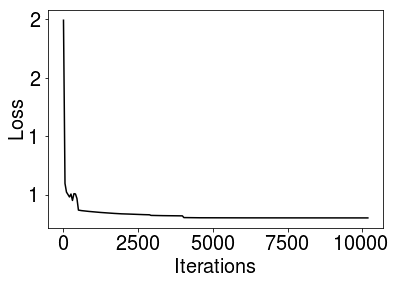

In [22]:
iterations = losses[:,0]
train_loss = losses[:,1]

fig, ax = plt.subplots(1,1)
utls.remove_tex_axis(ax)
ax.plot(iterations, train_loss,'-k')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
plt.savefig('LC1_LR_sched.png')

## Test network predictions

In [23]:
TEST_BATCH_SIZE = 128

In [28]:
model.test(x_test_flat,y_test_oh, TEST_BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./model
Average test loss: 1.462615966796875


INFO:tensorflow:Restoring parameters from ./model
Test sample digit: 8


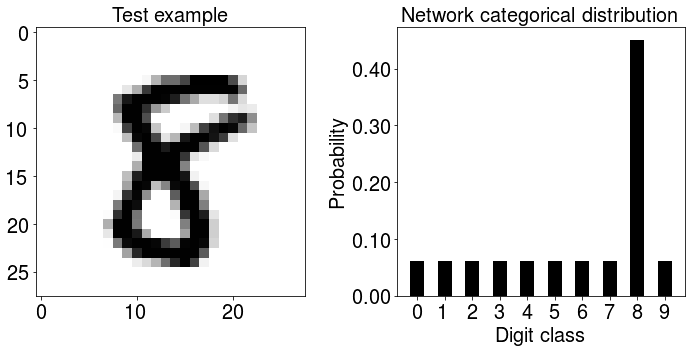

In [51]:
plt.close('all')
example = np.random.choice(n_test)

sample = x_test_flat[example]
label = y_test_oh[example]
feed_dict = {model.input: np.expand_dims(sample, axis=0), 
             model.ground_truth: np.expand_dims(label,axis=0)}

digit = np.where(label==1.0)[0][0]

with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./model.meta")
    saver.restore(sess, './model')
    prediction = sess.run(model.prediction, feed_dict = feed_dict)[0]

fig, axs = plt.subplots(1,2, figsize=(2*5,5))
axs = axs.ravel()

ax = axs[0]
utls.remove_tex_axis(ax)
ax.imshow(x_test[example],cmap=cm.binary)
ax.set_title('Test example')

classes = np.arange(10)
width = 0.5

ax = axs[1]

ax.bar(classes, prediction, width, color='Black')
utls.remove_tex_axis(ax,ytick_fmt="%.2f")
ax.set_xticks(classes)
ax.set_xticklabels([str(x) for x in np.arange(10)])
ax.set_ylabel('Probability')
ax.set_xlabel('Digit class')
ax.set_title('Network categorical distribution')

plt.tight_layout()
print('Test sample digit: {}'.format(digit))
